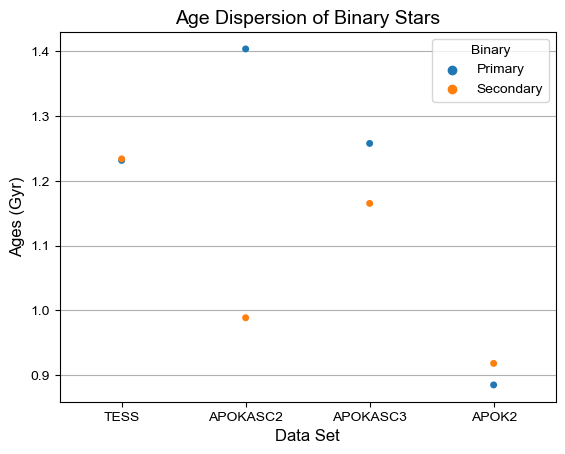

In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend

file='astraAllStarASPCAP-0.6.0.fits'
hdul=fits.open(file)
header=hdul[2].header
data=hdul[2].data

apogee_table = Table(data)
#apogee_table
# run^ to look for identifiers

# link to data: https://zenodo.org/records/4435257
# i selected: all_columns_catalog.fits.gz
# then unpacked
binary_file = 'all_columns_catalog.fits' # unzipped binary catalog
binaries = fits.open(binary_file)
binary_header = binaries[1].header
binary_data = binaries[1].data

binary_table = Table(binary_data)
binary_id = binary_table[['source_id1', 'source_id2']] # binary identifiers


#primary star mapping
primary = join(apogee_table, binary_table, keys_left='gaia_dr3_source_id', keys_right='source_id1', 
                           join_type='inner')
#secondary star mapping
secondary = join(apogee_table, binary_table, keys_left='gaia_dr3_source_id', keys_right='source_id2', 
                           join_type='inner')
wide_binaries = join(primary, secondary, keys=['source_id1', 'source_id2'], join_type='inner')

wide_binaries_data = wide_binaries[['tic_v8_id_1', 'source_id1', 'tic_v8_id_2', 'source_id2']] 
wide_binary = unique(wide_binaries_data, keys='source_id1')
wide_binary_table = wide_binary.to_pandas() # create a pandas dataframe of the wide binaries in the apogee catalog

# function to find the binary stars ages from each of the four methods, using the csv file of the age comparisons
def binary_matching(csv_file):
    tic_ages = pd.read_csv(csv_file)
    tic_identifier = tic_ages['TIC'].tolist()
    tic_binary = wide_binary_table[wide_binary_table['tic_v8_id_1'].isin(tic_identifier) & 
                                wide_binary_table['tic_v8_id_2'].isin(tic_identifier)].copy() # check tic numbers
    tic_binary = tic_binary[tic_binary['tic_v8_id_1'] != -1] # got a bunch of -1s for some reason, get rid of them
    merge1 = pd.merge(tic_binary, tic_ages, left_on='tic_v8_id_1', right_on='TIC', how='left')
    merge2 = pd.merge(merge1, tic_ages, left_on='tic_v8_id_2', right_on='TIC', how='left')
    merge2.rename(columns=lambda x: x.replace('_x', '_1').replace('_y', '_2'), inplace=True) # change suffix
    return merge2

tess_apokasc2 = binary_matching('TESS_APOKASC2_Comparison.csv')
tess_apokasc3 = binary_matching('TESS_APOKASC3_Comparison.csv')
tess_apok2 = binary_matching('TESS_APOK2_Comparison.csv')

#age selection
primary_tess_age = (tess_apokasc2['TESS_predicted_Gyr_1'][0] + tess_apokasc3['TESS_predicted_Gyr_1'][0] + 
                    tess_apok2['TESS_predicted_Gyr_1'][0])/3 # averaged the tess ages
secondary_tess_age = (tess_apokasc2['TESS_predicted_Gyr_2'][0] + tess_apokasc3['TESS_predicted_Gyr_2'][0] + 
                    tess_apok2['TESS_predicted_Gyr_2'][0])/3
primary_apokasc2_age = tess_apokasc2['APOKASC2_predicted_Gyr_1'][0]
secondary_apokasc2_age = tess_apokasc2['APOKASC2_predicted_Gyr_2'][0]
primary_apokasc3_age = tess_apokasc3['APOKASC3_predicted_Gyr_1'][0]
secondary_apokasc3_age = tess_apokasc3['APOKASC3_predicted_Gyr_2'][0]
primary_apok2_age = tess_apok2['APOK2_predicted_Gyr_1'][0]
secondary_apok2_age = tess_apok2['APOK2_predicted_Gyr_2'][0]

# create a data frame of the ages, star, and method
ages = {
    'Set': ['TESS', 'TESS', 'APOKASC2', 'APOKASC2', 'APOKASC3', 'APOKASC3', 'APOK2', 'APOK2'],
    'Binary': ['Primary', 'Secondary', 'Primary', 'Secondary', 'Primary', 'Secondary', 'Primary', 'Secondary'],
    'Ages': [primary_tess_age, secondary_tess_age, primary_apokasc2_age, secondary_apokasc2_age, primary_apokasc3_age, 
             secondary_apokasc3_age, primary_apok2_age, secondary_apok2_age]
}
ages_table = pd.DataFrame(ages)

plt.figure()
sns.stripplot(data=ages_table, x='Set', y='Ages', hue='Binary', dodge=False, jitter=False)
plt.ylabel('Ages (Gyr)')
plt.xlabel('Data Set')
plt.title('Age Dispersion of Binary Stars')
plt.grid(True, axis='y')
plt.show()

#tess yields least dispersion